# Lab5: Constrained Optimization: Equality and Inequality Constraints

## Tom Rolandus and Peter Weber

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
import math
import autoreload
import random
from sklearn import svm
%load_ext autoreload
%autoreload 2

%matplotlib inline

### NLA Helpers

In [2]:
# M_kkt matrix
def get_M_kkt(lambda_, s_, G_, A_, C_):
    n_ = G_.shape[0]
    p_ = A_.shape[1]
    m_ = len(lambda_)
    M_kkt1_ = np.c_[G_, -A_, -C_, np.zeros((n_, m_))]
    M_kkt2_ = np.c_[-A_.T, np.zeros((p_, p_)), np.zeros((p_, m_)), np.zeros((p_, m_))]
    M_kkt3_ = np.c_[-C_.T, np.zeros((m_, p_)), np.zeros((m_, m_)), np.identity(m_)]
    M_kkt4_ = np.c_[np.zeros((m_, n_)), np.zeros((m_, p_)), np.diag(s_), np.diag(lambda_)]
    return (np.r_[M_kkt1_, M_kkt2_, M_kkt3_, M_kkt4_])


# Define F(z)
def F(x_, gamma_, lambda_, s_, G_, A_, C_, g_, b_, d_):
    F1_ = np.dot(G_, x_) + g_ + np.dot(-A_, gamma_) + np.dot(-C_, lambda_)
    F2_ = np.dot(-A_.T, x_) + b_
    F3_ = np.dot(-C_.T, x_) + d_ + s_
    F4_ = lambda_ * s_
    return (np.r_[F1_, F2_, F3_, F4_])


# Define right-hand side vectors for unconstraint case
def r_1(x_, gamma_, lambda_, s_, G_, A_, C_, g_, b_, d_):
    return (np.dot(G_, x_) + g_ + np.dot(-A_, gamma_) + np.dot(-C_, lambda_))


def r_2(x_, gamma_, lambda_, s_, G_, A_, C_, g_, b_, d_):
    return (np.dot(-C_.T, x_) + d_ + s_)


def r_3(x_, gamma_, lambda_, s_, G_, A_, C_, g_, b_, d_):
    return (lambda_ * s_)


# Execute 6 steps C2
def get_new_z(x_, gamma_, lambda_, s_, G_, A_, C_, g_, b_, d_, e_):
    n_ = len(x_)
    p_ = len(gamma_)
    m_ = len(lambda_)
    z_ = np.r_[x_, gamma_, lambda_, s_]

    # Step 1
    F_ = -F(x_, gamma_, lambda_, s_, G_, A_, C_, g_, b_, d_)
    M_kkt_ = get_M_kkt(lambda_, s_, G_, A_, C_)
    dz_ = np.linalg.solve(M_kkt_, F_)
    dlambda_ = dz_[(n_ + p_):(n_ + p_ + m_)]
    ds_ = dz_[(n_ + p_ + m_):(n_ + p_ + 2 * m_)]

    # Step 2
    alpha_ = Newton_step(lambda_, dlambda_, s_, ds_)

    # Step 3
    mu_ = np.inner(s_.T, lambda_) / m_
    mu_tilde_ = np.inner((s_ + alpha_ * ds_).T, lambda_ + alpha_ * dlambda_) / m_
    sigma_ = (mu_tilde_ / mu_) ** 3

    # Step 4
    s_correction_ = np.dot(np.dot(np.diag(ds_), np.diag(dlambda_)), e_) - sigma_ * mu_ * e_
    F_[(n_ + p_ + m_):(n_ + p_ + 2 * m_)] = F_[(n_ + p_ + m_):(n_ + p_ + 2 * m_)] - s_correction_
    dz_ = np.linalg.solve(M_kkt_, F_)
    dx_ = dz_[0:n_]
    dgamma_ = dz_[n_:(n_ + p_)]
    dlambda_ = dz_[(n_ + p_):(n_ + p_ + m_)]
    ds_ = dz_[(n_ + p_ + m_):(n_ + p_ + 2 * m_)]

    # Step 5
    alpha_ = Newton_step(lambda_, dlambda_, s_, ds_)

    # Step 6
    z_ = z_ + 0.95 * alpha_ * dz_
    x_ = z_[0:n_]
    gamma_ = z_[n_:(n_ + p_)]
    lambda_ = z_[(n_ + p_):(n_ + p_ + m_)]
    s_ = z_[(n_ + p_ + m_):(n_ + p_ + 2 * m_)]

    return (z_, mu_, -F(x_, gamma_, lambda_, s_, G_, A_, C_, g_, b_, d_))

# Newton step
def Newton_step(lamb0,dlamb,s0,ds):
    alp=1;
    idx_lamb0=np.array(np.where(dlamb<0))
    if idx_lamb0.size>0:
        alp = min(alp,np.min(-lamb0[idx_lamb0]/dlamb[idx_lamb0]))
    idx_s0=np.array(np.where(ds<0))
    if idx_s0.size>0:
        alp = min(alp,np.min(-s0[idx_s0]/ds[idx_s0]))
    return alp

#%% THE INTERIOR ALGORITHM FROM NLA
def interior_point_algorithm(X, Y, m, K,
                             iter_max = 1000, eps = 1e-16,
                             print_iter = True, print_conv = True):
    n_nla = m
    p_nla = 1
    m_nla = 2 * m

    G = Y.dot(X.T).dot(X).dot(Y)
    A = np.diag(Y).reshape((n_nla,1))
    C = np.c_[np.diag([1] * n_nla), np.diag([-1] * n_nla)]

    x = np.zeros(n_nla)
    gamma = np.zeros(p_nla)
    s = np.ones(m_nla)
    lamb = np.ones(m_nla)
    g = np.array([-1]*n_nla)
    b = np.array([0]*p_nla)
    d = np.r_[[0]*m, [-K]*m]
    e = np.ones(m_nla)
    
    for i in range(iter_max):
        result = get_new_z(x, gamma, lamb, s, G, A, C, g, b, d, e)
        z = result[0]
        mu = result[1]
        righthand = result[2]

        x = z[:n_nla]
        gamma = z[n_nla:n_nla + p_nla]
        lamb = z[n_nla + p_nla:n_nla + p_nla + m_nla]
        s = z[n_nla + p_nla + m_nla:n_nla + p_nla + 2 * m_nla]

        r_l = np.linalg.norm(righthand[0:n_nla])
        r_c = np.linalg.norm(righthand[n_nla + p_nla:n_nla + p_nla + m_nla])

        if print_iter:
            print("iteration: ", i)
            print("r_L: ", r_l)
            print("r_C: ", r_c)
            print("mu: ", mu, "\n")

        if math.fabs(mu) < eps or r_l < eps or r_c < eps:
            if print_conv:
                M = get_M_kkt(lamb, s, G, A, C)
                condition_number = np.linalg.cond(M)
                print("Convergence after ", i, " iterations!!!")
            break
        error = np.sum(x + g)
    return(x, error)

### Lab5 Helpers

In [17]:
def get_X(mean1, mean2, cov1, cov2, n1, n2, seed = 42):
    # n1 + n2 is the number of data points
    # dim(X) = n x (n1 + n2) = 2 x (n1 + n2)
    np.random.seed(seed)
    X0 = np.random.multivariate_normal(mean1,cov1,n1).T
    X1 = np.random.multivariate_normal(mean2,cov2,n2).T
    X = np.c_[X0, X1]
    return(X, X0, X1)

def get_Y(n1, n2):
    # n1 + n2 is the number of data points
    # dim(Y) = (n1 + n2) x (n1 + n2)
    y0 = [-1]*n1
    y1 = [1]*n2
    return(np.diag(y0+y1), np.array(y0+y1))

def compute_w(X, y, alpha):
    w = np.zeros(X.shape[0])
    for i in range(X.shape[1]):
        w += alpha[i] * y[i] * X[:, i]
    return(w)

def compute_b(X,y,alpha, K, w):
    indices_sorted = np.argsort(alpha)
    alpha_sorted = alpha[indices_sorted]
    X_sorted = X[:, indices_sorted]
    y_sorted = y[indices_sorted]

    for i in range(len(alpha_sorted)-1, -1, -1):
        if alpha_sorted[i] > 0 and alpha_sorted[i] < K:
            b = y_sorted[i] - w.dot(X_sorted[:, i])
            break
    return b

def get_plane_parameters(X, Y, m, K):
    # Run interior point algorithm to extract alpha
    alpha, _ = interior_point_algorithm(X, Y, m, K, print_iter = False)

    # compute w and b
    y = np.diag(Y)
    w = compute_w(X, y, alpha)
    b = compute_b(X, y, alpha, K, w)
    print('w: %s, b: %s' %(w,b))
    return _, w, b

def plot_hyperplane(X,w,b,format_sep_hp = "-k", format_sup_vec = "--r", alpha_sup = 1,label = ""):
    x = np.linspace(min(X[0,:]), max(X[0,:]),10)
    plane = -b/w[1] - w[0]/w[1]*x
    plane_lower = plane - 1/w[1]
    plane_upper = plane + 1/w[1]
    plt.plot(x, plane, format_sep_hp, label = label)
    plt.plot(x, plane_lower, format_sup_vec, alpha = alpha_sup)
    plt.plot(x, plane_upper, format_sup_vec, alpha = alpha_sup)
    
def plot_points(X0,X1):
    plt.plot(X0[0,:], X0[1,:], '.', color = 'blue', markersize = 10)
    plt.plot(X1[0,:], X1[1,:], '.', color = 'green', markersize = 10)

### Data separable case and comparison with Oriol's results
We will now test the Interior point dual method on a separable dataset using different values for K. We compare these results with the ones obtained using Oriol's method, namely sklearn.svm , on the same dataset. The C parameter of the sklearn.svm corresponds to K in the interior point dual method.

In [4]:
# Parameters for data
m1 = [0., 0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2 = [3., 6.]  
s2 = [[1,0],[0,1]]

# number of data points
n1, n2 = 80, 80
m = n1 + n2

# Generate data
X_sep, X0_sep, X1_sep = get_X(m1,m2,s1,s2,n1,n2)
Y_sep, y_sep = get_Y(n1, n2)


 
----------- K = C = 1e0 -------------
Interior Point Dual:
Convergence after  18  iterations!!!
w: [0.25645706 0.53182676], b: -1.5842890750189076

 sklearn.svm:
w: [-0.25642209 -0.53175425], b: 1.5840730437495871

 
----------- K = C = 1e2 -------------
Interior Point Dual:
Convergence after  36  iterations!!!
w: [0.25645706 0.53182676], b: -1.5842890750189182

 sklearn.svm:
w: [-0.25642209 -0.53175425], b: 1.5840730437495871

 
----------- K = C = 1e4 -------------
Interior Point Dual:
Convergence after  49  iterations!!!
w: [0.25645706 0.53182676], b: -1.584289075018912

 sklearn.svm:
w: [-0.25642209 -0.53175425], b: 1.5840730437495871


[]

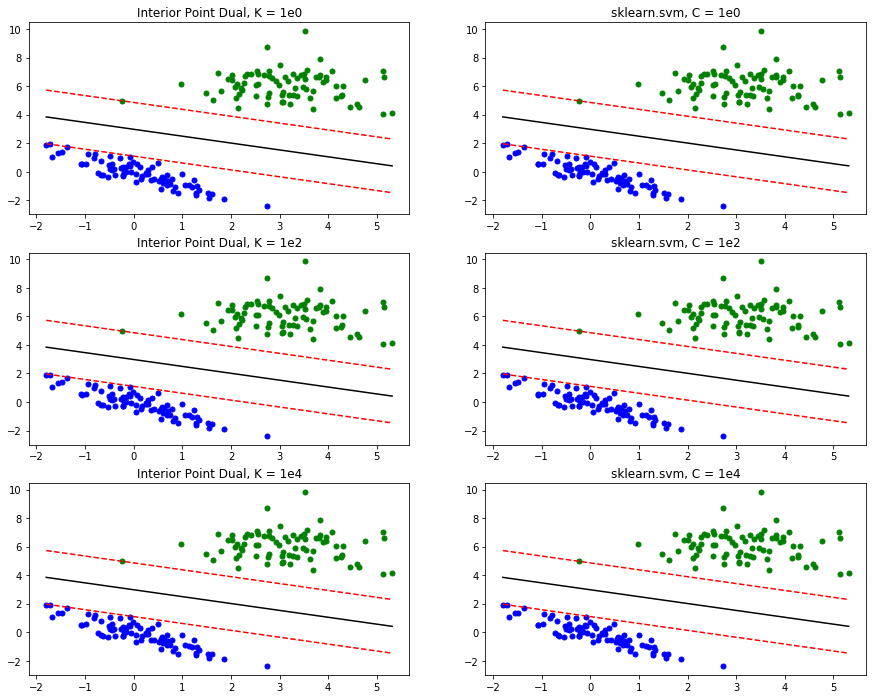

In [5]:
nb_exps = 3
plt.figure(figsize = (15, 4 * nb_exps))
i = 0
while i <= (nb_exps-1) * 2:
    expo = i
    K = 10**expo
    print('\n \n----------- K = C = 1e%s -------------' %expo)
    print('Interior Point Dual:')
    plt.subplot(nb_exps,2,i+1)
    _, w, b = get_plane_parameters(X_sep, Y_sep, m, K = K)
    plot_points(X0_sep, X1_sep)
    plot_hyperplane(X_sep, w, b)
    plt.title("Interior Point Dual, K = 1e" + str(expo))
    
    i+=1


    Y_array = np.concatenate([np.ones((n1,1)),-np.ones((n2,1))])
    clf = svm.SVC(kernel='linear', C = K)
    clf.fit(X_sep.T,Y_array.ravel())
    print("\n sklearn.svm:")
    print("w: %s, b: %s" %(clf.coef_[0], clf.intercept_[0]))
    plt.subplot(nb_exps,2,i+1)
    plot_points(X0_sep, X1_sep)
    plot_hyperplane(X_sep, clf.coef_[0], clf.intercept_[0])
    plt.title("sklearn.svm, C = 1e" + str(expo))
    
    i+=1


plt.plot()

 We see that the interior point dual method and the sklearn.svm yield, when inversing the signs, almost identical results for different values of K = C tested. The small difference in the results of both methods is probably due to rounding and tolerance. The results obtained are in line with what we expected, given that in the separable case the solution is unique it makes sense that the algorithms converge to the same results with different Ks. We do note however, that for large values of K (>1e6) the interior point dual method often gets stuck on a singular matrix. Sklearn.svm does not output the number of iterations until convergence, but our implementation does and we can see that it increases as K increases.

### Data non-separable case and comparison with Oriol's results
 We will now test the Interior point dual method on a non-separable dataset using different values for K.  As previously, we will compare these results with the ones obtained using Oriol's method on the same data.

In [6]:
# Parameters for data
m1 = [0.,0.]
m2 = [1.,2.]  
s1 = [[1,-0.9],[-0.9,1]]
s2 = [[1,0],[0,1]]

# number of data points
n1, n2 = 80, 80
m = n1 + n2

# Generate data
X_nonsep, X0_nonsep, X1_nonsep = get_X(m1,m2,s1,s2,n1,n2)
Y_nonsep, y_nonsep = get_Y(n1, n2)


 
----------- K = C = 1e0 -------------
Interior Point Dual:
Convergence after  19  iterations!!!
w: [1.39419392 1.86594123], b: -2.0736231269362824

 sklearn.svm:
w: [-1.39435707 -1.86615973], b: 2.073826847541144

 
----------- K = C = 1e1 -------------
Interior Point Dual:
Convergence after  32  iterations!!!
w: [1.70241244 2.21838652], b: -2.3537329144842913

 sklearn.svm:
w: [-1.70157803 -2.21729869], b: 2.3527428986174006

 
----------- K = C = 1e2 -------------
Interior Point Dual:
Convergence after  45  iterations!!!
w: [1.94400084 2.53319652], b: -2.545840397018724

 sklearn.svm:
w: [-1.94359028 -2.53289816], b: 2.5457154657890766

 
----------- K = C = 1e3 -------------
Interior Point Dual:
Convergence after  47  iterations!!!
w: [1.94400084 2.53319652], b: -2.5458403970184533

 sklearn.svm:
w: [-1.94386275 -2.53319283], b: 2.545879987389741

 
----------- K = C = 1e4 -------------
Interior Point Dual:
Convergence after  53  iterations!!!
w: [1.94400084 2.53319652], b: -2.54

[]

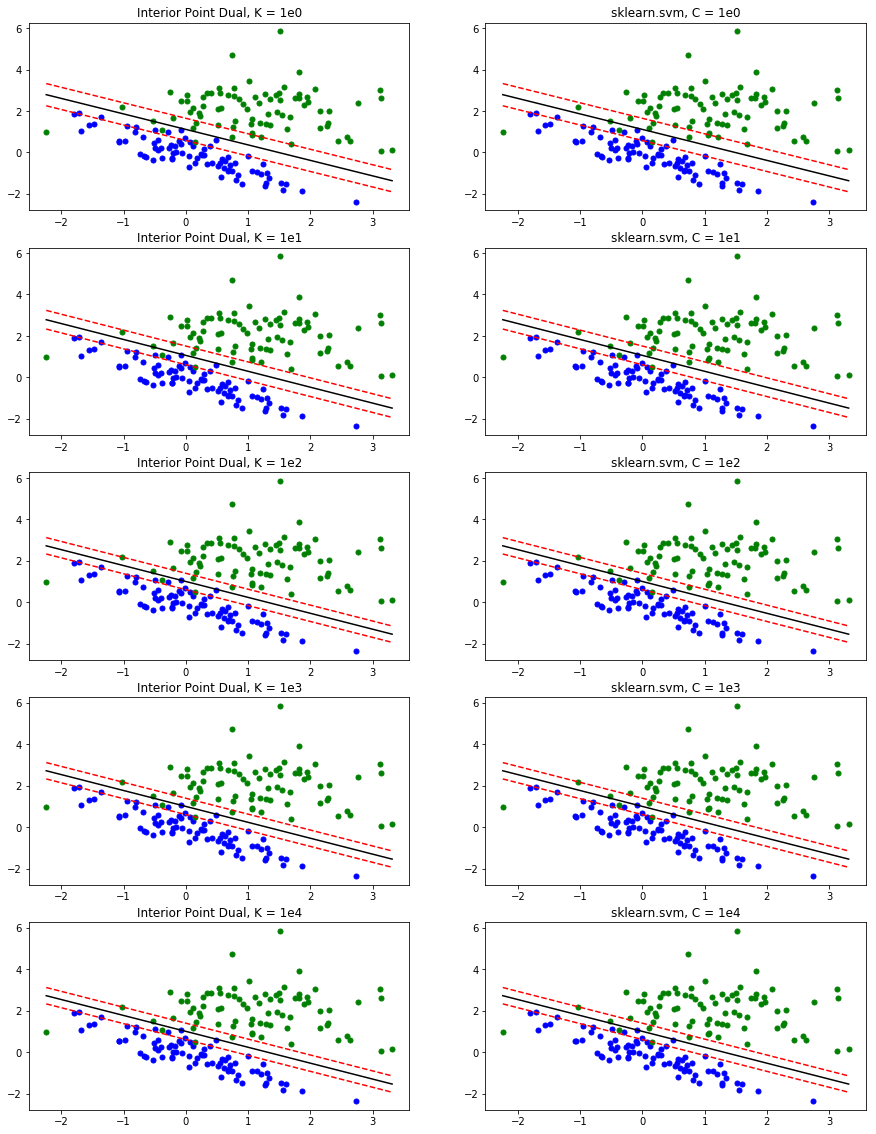

In [7]:
nb_exps = 5
plt.figure(figsize = (15, 4 * nb_exps))
i = 0
while i <= (nb_exps-1) * 2:
    expo = int(i/2)
    K = 10**expo
    print('\n \n----------- K = C = 1e%s -------------' %expo)
    print('Interior Point Dual:')
    plt.subplot(nb_exps,2,i+1)
    _, w, b = get_plane_parameters(X_nonsep, Y_nonsep, m, K = K)
    plot_points(X0_nonsep, X1_nonsep)
    plot_hyperplane(X_nonsep, w, b)
    plt.title("Interior Point Dual, K = 1e" + str(expo))
    
    i+=1


    Y_array = np.concatenate([np.ones((n1,1)),-np.ones((n2,1))])
    clf = svm.SVC(kernel='linear', C = K)
    clf.fit(X_nonsep.T,Y_array.ravel())
    print("\n sklearn.svm:")
    print("w: %s, b: %s" %(clf.coef_[0], clf.intercept_[0]))
    plt.subplot(nb_exps,2,i+1)
    plot_points(X0_nonsep, X1_nonsep)
    plot_hyperplane(X_nonsep, clf.coef_[0], clf.intercept_[0])
    plt.title("sklearn.svm, C = 1e" + str(expo))
    
    i+=1


plt.plot()

 Again, we see that the interior point dual method and Oriol's method yield almost identical results when inversing the signs. It is interesting to note that in the non-separable case the results differ with different values of K = C. Given that the solution is not unique, using different values for K changes the results as it adds more or less weight to violating the separation. In this case, values of K >= 1e2 barely influence the results anymore. 

# Lab6: Stochastic and Mini-batch Gradient Descent

In [8]:
def sgd_grad_update(x, y, w, b, gamma, lambda_):
    keep_last_term = y * (w.dot(x) + b) <= 1
    w = w - gamma * (lambda_ * w - y * x * keep_last_term)
    b = b + gamma * y * keep_last_term
    return w, b

def mini_batch_grad_update(X, y, w, b, gamma, lambda_):
    keep_last_term = np.multiply(y, (w.dot(X) + b)) <= 1
    w = w - gamma * (lambda_ * w - X.dot(np.multiply(y, keep_last_term)))
    b = b + gamma * y.dot(keep_last_term)
    return w, b

def objective(X, y, w, b, lambda_):
    loss = np.sum(np.maximum(np.zeros(y.shape[0]), 1 - y * (w.dot(X) + b)))
    regularization = lambda_/2. * w.dot(w) 
    return loss + regularization

In [9]:
def sgd(X, y, K, epochs, count = 1e2):
    
    # indices for shuffling
    indices = list(range(y.shape[0]))
    
    # initialize 
    w, b = np.random.random((2,)), np.random.random(1)
    lambda_ = 1./K
    loss = []
    
    for _ in range(epochs):    
        # shuffle indices
        random.shuffle(indices)
        
        # append objective
        loss.append(np.log(objective(X, y, w, b, lambda_)))
        
        for idx in indices:
            # perform gradient update
            w, b = sgd_grad_update(X[:,idx], y[idx], w, b, 1./count, lambda_)
        # decrease gamma
        count += 1
                
    return loss, w, b

def mini_batch(X, y, K, epochs, batch_size, count = 1e2):
    
    # indices for shuffling
    N = y.shape[0]
    indices = list(range(N))
    
    # initialize 
    w, b = np.random.random((2,)), np.random.random(1)
    lambda_ = 1./K
    loss = []
    
    for _ in range(epochs):    
        # shuffle indices
        random.shuffle(indices)
        # append objective
        loss.append(np.log(objective(X, y, w, b, lambda_)))
        
        for idx in range(0, N, batch_size):      
            # get data points in batch
            batch_idx = indices[idx:(idx+batch_size)]

            X_batch = X[:,batch_idx]
            y_batch = y[batch_idx]
            
            # perform gradient update
            w, b = mini_batch_grad_update(X_batch, y_batch, w, b, 1./count, lambda_)
            # decrease gamma
            count += 1

    return loss, w, b


## Pure Stochastic Gradient Descent with separable data set

Let us test the pure Stochastic Gradient Descent on a separable dataset with different values of $K$, where $\lambda = 1/K$

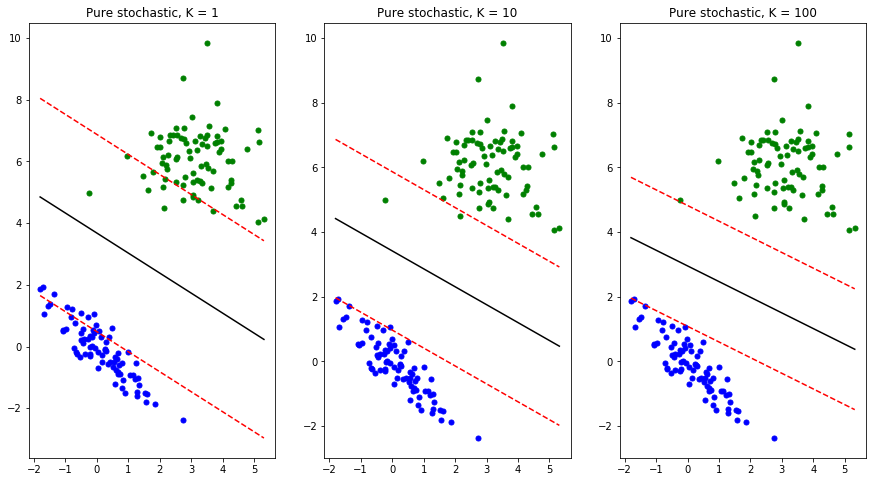

In [10]:
plt.figure(figsize = (15, 8))

plt.subplot(1,3,1)
loss_fct_sgd, w, b = sgd(X_sep, y_sep, K = 1, epochs = 1000, count = 100)
plot_points(X0_sep, X1_sep)
plot_hyperplane(X_sep, w, b)
plt.title("Pure stochastic, K = 1")

plt.subplot(1,3,2)
loss_fct_sgd, w, b = sgd(X_sep, y_sep, K = 10, epochs = 1000, count = 100)
plot_points(X0_sep, X1_sep)
plot_hyperplane(X_sep, w, b)
plt.title("Pure stochastic, K = 10")

plt.subplot(1,3,3)
loss_fct_sgd, w, b = sgd(X_sep, y_sep, K = 100, epochs = 1000, count = 100)
plot_points(X0_sep, X1_sep)
plot_hyperplane(X_sep, w, b)
plt.title("Pure stochastic, K = 100")

plt.show()

We can see that as $K$ increases ($\lambda$ decreases) the Pure Stochastic Gradient Descent seems to perform better.

### Mini-batch gradient descent
We will now test this method with different batch sizes and values of $K$

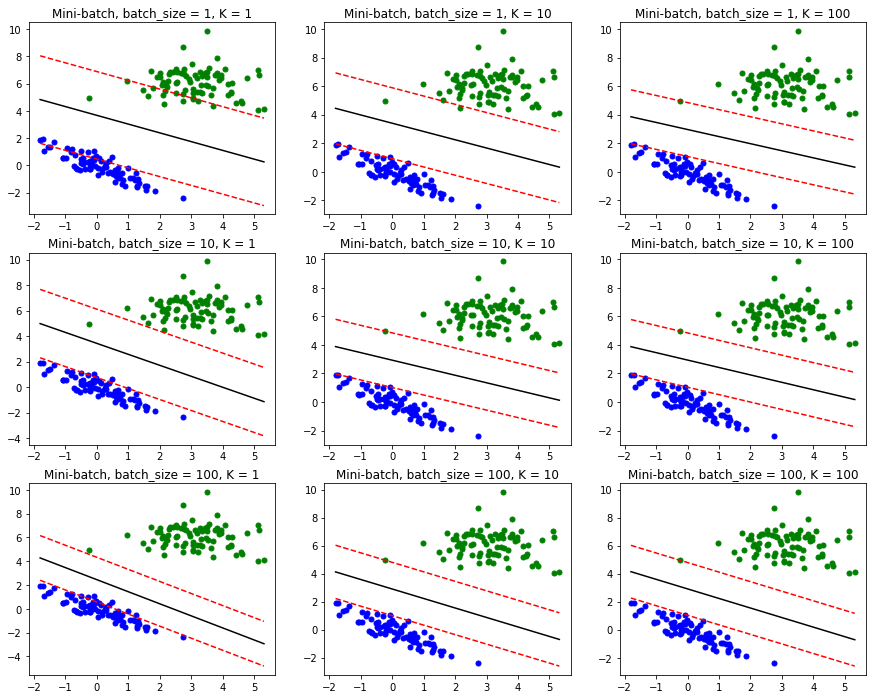

In [11]:
nb_ks = 3
nb_batches = 3

plt.figure(figsize=(nb_ks * 5,nb_batches * 4))
plot_pos = 0
for i in range(1,nb_ks+1):
    k = 10**(i-1)
    for j in range(1,nb_batches+1):
        batch = 10**(j-1)
        plot_pos += 1
        plt.subplot(nb_ks,nb_batches,plot_pos)
        loss_fct_mini, w, b = mini_batch(X_sep, y_sep, K = k, epochs = 1000, batch_size = batch, count = 100)
        plot_points(X0_sep, X1_sep)
        plot_hyperplane(X_sep, w, b)
        plt.title("Mini-batch, batch_size = %s, K = %s" %(k,batch))
plt.show()

The above graphs show that the Mini-batch gradient descent performs best when $K$ and the batch size are large. Inversely, it performs poorly when both are small.

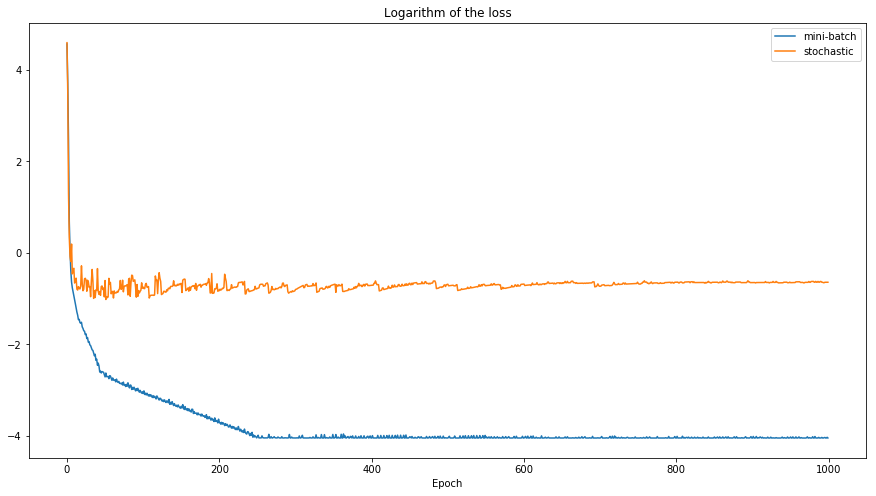

In [12]:
loss_fct_mini, _, __ = mini_batch(X_sep, y_sep, K = 10, epochs = 1000, batch_size = 10, count = 100)
loss_fct_sgd, _, __ = sgd(X_sep, y_sep, K = 10, epochs = 1000, count = 100)

plt.figure(figsize=(15,8))
plt.plot(range(len(loss_fct_mini)), loss_fct_mini, label = "mini-batch")
plt.plot(range(len(loss_fct_sgd)), loss_fct_sgd, label = "stochastic")
plt.xlabel("Epoch")
plt.title("Logarithm of the loss")
plt.legend()
plt.show()

## Comparison between Interior Point Algorithm in the dual with Stochastic Gradient Descent and Mini-batch Gradient Descent

In [13]:
loss_fct_sgd, w_sgd, b_sgd = sgd(X_sep, y_sep, K = 100, epochs = 1000, count = 100)
loss_fct_mini, w_mini, b_mini = mini_batch(X_sep, y_sep, K = 100, epochs = 1000, batch_size = 100, count = 100)
_, w_dual, b_dual = get_plane_parameters(X_sep, Y_sep, m, K = 100)

Convergence after  36  iterations!!!
w: [0.25645706 0.53182676], b: -1.5842890750189182


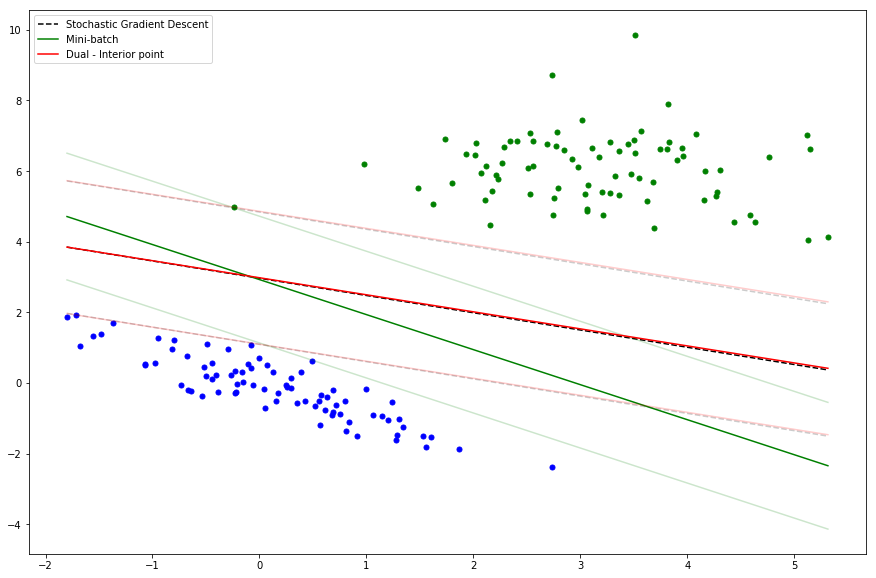

In [18]:
plt.figure(figsize = (15, 10))
plot_points(X0_sep, X1_sep)
plot_hyperplane(X_sep, w_sgd, b_sgd, format_sep_hp = "--k", format_sup_vec = "--k",alpha_sup=0.2, label='Stochastic Gradient Descent')
plot_hyperplane(X_sep, w_mini, b_mini, format_sep_hp = "-g", format_sup_vec = "-g",alpha_sup=0.2, label='Mini-batch')
plot_hyperplane(X_sep, w_dual, b_dual, format_sep_hp = "-r", format_sup_vec = "-r",alpha_sup=0.2, label='Dual - Interior point')
plt.legend(loc=2, ncol=1)

In this last plot we observe that the Pure Stochastic Gradient Descent (the dashed lines) and the Interior Point Algorithm (red lines) have almost identical parameters, while the mini-batch gradient descent ($K = 100$, green lines) is considerably different. Nevertheless, all of these solutions fit the data well.